In [2]:
### Heat equation: du/dt = Laplace(u) + f

In [3]:
from fenics import *
import numpy as np
from IPython.display import HTML
import matplotlib.pyplot as plt

In [55]:
def calculate_simulation(nx, ny, nt, dt=None, tmax=None):
    if dt is not None and tmax is not None:
        raise ValueError("For a given number of points, dt and tmax cannot both be defined.")
    elif dt is None and tmax is None:
        raise ValueError("For a given number of points, either dt or tmax should be set.")
    elif dt is None:
        dt = tmax/nt
    elif tmax is None:
        tmax = dt*nt
    
    # Mesh setup
    mesh = UnitSquareMesh(nx, ny)
    mesh_info = {'mesh':mesh, 'nx':nx, 'ny':ny, 'nt':nt, 'dt':dt, 'tmax':tmax}

    # Functions setup
    V = FunctionSpace(mesh, 'P', 1)
    u = TrialFunction(V)
    v = TestFunction(V)

    # Boundary setup
    def boundary(x, on_boundary):
        return on_boundary
    alpha = 6
    beta = 1.2
    u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t', degree=2, alpha=alpha, beta=beta, t=0)
    bc = DirichletBC(V, u_D, boundary)

    # Initial values
    t = 0
    u_n = interpolate(u_D, V)

    # Variational problem
    f = Constant(beta - 2 - 2*alpha)
    a = u*v*dx + dt*dot(grad(u), grad(v))*dx
    L = (dt*f+u_n)*v*dx
    
    # Logs
    logs = {'t':[], 'u':[], 'error_L2':[], 'error_max':[]}
    
    #Log initial values
    logs['t'].append(t)
    logs['u'].append(u_n.copy(deepcopy=True))
    logs['error_L2'].append(0)
    logs['error_max'].append(0)
    
    # Solving
    u = Function(V)
    for i in range(nt):
        t += dt
        u_D.t = t
        solve(a == L, u, bc)
        u_n.assign(u)

        #Get error
        vertex_values_u_D = u_D.compute_vertex_values(mesh).reshape(nx+1, ny+1)
        vertex_values_u = u.compute_vertex_values(mesh).reshape(nx+1, ny+1)
        error_L2 = errornorm(u_D, u_n, norm_type='L2')
        error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))

        # Log current values
        logs['t'].append(t)
        logs['u'].append(u_n.copy(deepcopy=True))
        logs['error_L2'].append(error_L2)
        logs['error_max'].append(error_max)
        
    return mesh_info, logs

mesh_info, logs = calculate_simulation(10, 10, 20, tmax=4.0)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


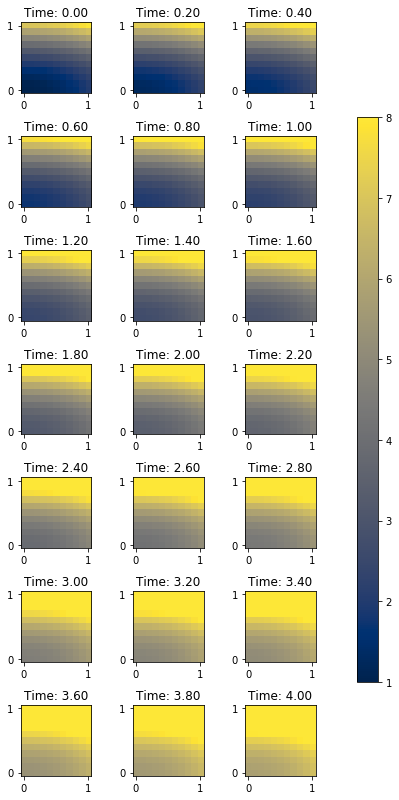

In [56]:
def display_simulation(mesh_info, logs, nplots_max=None, nrows_max=None, show_bounds=False):

    # Retrieve variables
    mesh = mesh_info['mesh']
    nx = mesh_info['nx']
    ny = mesh_info['ny']
    nt = mesh_info['nt']
    u_hist = logs['u']
    t_hist = logs['t']

    # Default values
    if nplots_max is None: 
        nplots_max = 1e19
    if nrows_max is None:
        nrows_max = 1e19
    nplots = min(nt+1, nplots_max)
    skipper = int(np.ceil((nt+1)/nplots))

    ncols = int(np.ceil(nplots/nrows_max))
    nrows = int(np.ceil(nplots/ncols))
    figsize = [2*ncols, 0.8*nrows*2]     # figure size, inches
    scalemin, scalemax = 1.0, 8.0 #Decided arbitrarily to scale the plots to a standard scale.
                               #Ideally, we would scale everything based on the min and max over all time,
                               #but here we are plotting before doing the entire calculation.

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)


    for i in range(nplots):
        axi = axes.flat[i]
        # i runs from 0 to (nrows*ncols-1)
        # axi is equivalent with ax[rowid][colid]
        vertex_values_u = u_hist[i].compute_vertex_values(mesh).reshape(nx+1, ny+1)
        img = axi.imshow(vertex_values_u, origin='lower', extent=(-0.05, 1.05, -0.05, 1.05), cmap='cividis', vmin=scalemin, vmax=scalemax)
        
        axi.set_title(f'Time: {t_hist[i]:.2f}')
        
        if show_bounds:
            maj_locator = plt.FixedLocator([0, 1])
        if not show_bounds:
            maj_locator = plt.NullLocator()
        axi.xaxis.set_major_locator(maj_locator)
        axi.yaxis.set_major_locator(maj_locator)
        axi.xaxis.set_minor_locator(plt.NullLocator())
        axi.yaxis.set_minor_locator(plt.NullLocator())

    plt.tight_layout(True)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(img, cax=cbar_ax)

    plt.show()
    
display_simulation(mesh_info, logs, nrows_max=7, show_bounds=True)

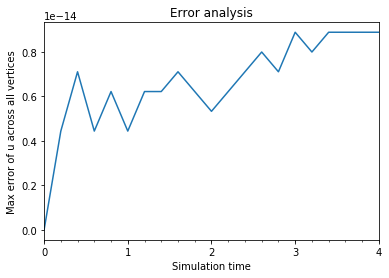

(<matplotlib.axes._subplots.AxesSubplot at 0x7f7fb1e0db70>,
 <matplotlib.lines.Line2D at 0x7f7fb1ce4860>)

In [75]:
def display_error(error_type, mesh_info, logs, prev_ax=None, major_ticks_period=1, show=True):
    #the simulation time is displayed every 'major_ticks_period' times the timestep dt
    #'show' is false when the function is used as an intermediate step (if the axis will be used for further plotting)
    
    if prev_ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    else:
        ax = prev_ax
    
    artist, = ax.plot(logs['t'], logs['error_'+error_type])
    ax.margins(x=0)
    
    ax.set_title('Error analysis')
    ax.set_xlabel('Simulation time')
    ax.set_ylabel('Max error of u across all vertices')
    
    if show:
        ax.xaxis.set_major_locator(plt.MultipleLocator(mesh_info['dt']*major_ticks_period))
        ax.xaxis.set_minor_locator(plt.MultipleLocator(mesh_info['dt']))
        plt.show()
    return ax, artist
    
display_error('max', mesh_info, logs, major_ticks_period=5)

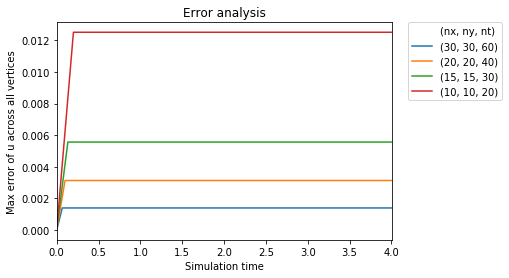

In [95]:
from matplotlib.patches import Patch

def display_errors(error_type, nxs, nys, nts, tmax):
    nxs, nys, nts = np.sort(nxs)[::-1], np.sort(nys)[::-1], np.sort(nts)[::-1]
    
    # Display setup
    prev_ax = None
    artists = []
    
    # Reuse smallest value of n_s if their are smaller values of a different n_s to get through
    len_max = max(len(nxs), len(nys), len(nts))
    for n_s in [nxs, nys, nts]:
        if len(n_s) < len_max:
            n_missing = len_max - len(n_s)
            n_s = n_s + [n_s]*n_missing
    
    # Iteration
    for i in range(len_max):
            
        # calculation step
        mesh_info, logs = calculate_simulation(nxs[i], nys[i], nts[i], tmax=tmax)
        
        # display step
        prev_ax, prev_art = display_error(error_type, mesh_info, logs, prev_ax=prev_ax, show=False)
        artists.append(prev_art)
        
    # Final touches
    empty_artist = Patch(color='white', label=str((nxs, nys, nts)))
    prev_ax.legend([empty_artist]+artists, ['(nx, ny, nt)']+list(zip(nxs, nys, nts)), 
                   bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()
            
display_errors('L2', [10, 15, 20, 30], [10, 15, 20, 30], [20, 30, 40, 60], 4.0)

In [142]:
def calculate_convergence(initial_n, increase_factor_n, iterations, tmax):
    #increase_factor_n is decides how many more points are in the nest mesh
    if type(increase_factor_n) is not int:
        raise ValueError("increase_factor_n should be an integer")
    if initial_n <= 0 or type(initial_n) is not int:
        raise ValuError("initial_n should be a positive integer")
    
    # Logs
    hs = []
    errors_L2 = []
    
    for i in range(iterations):
        if i == 0:
            n = initial_n
        else:
            n *= increase_factor_n
        mesh_info, logs = calculate_simulation(n, n, n, tmax=tmax)
        print(n)
        hs.append(1/n)
        errors_L2.append(logs['error_L2'][-1])
        
    hs = np.array(hs)
    errors_L2 = np.array(errors_L2)
    convergence_rates = np.log(errors_L2[1:]/errors_L2[:-1])/np.log(hs[1:]/hs[:-1])
    return hs[1:], convergence_rates

hs, convergence_rates = calculate_convergence(8, 2, 5, 4.0)

8
16
32
64
128


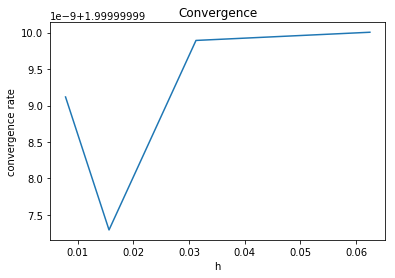

In [144]:
def display_convergence(hs, convergence_rates):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.plot(hs, convergence_rates)
    
    ax.set_title("Convergence")
    ax.set_xlabel("h")
    ax.set_ylabel("convergence rate")
    
    plt.show()
    
display_convergence(hs, convergence_rates)

In [129]:
### other

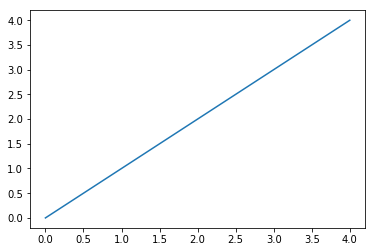

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(np.arange(5))
plt.show()
ax.plot(np.arange(3)+1)
plt.show()

In [ ]:
uvals = u_hist[0].compute_vertex_values()
xyvals = mesh.coordinates()
xvals = xyvals[:,0]
yvals=xyvals[:,1]

xx = np.linspace(0,1)
yy = np.linspace(0,1)

XX, YY = np.meshgrid(xx,yy)

from scipy.interpolate import griddata
uu = griddata(xyvals, uvals, (XX, YY), method='linear')
plt.imshow(uu, origin='lower', extent=(-5e-3, 1+5e-3, -5e-3, 1+5e-3))